# Geospatial Transforms 

## Author(s)

Tyler Sutterley, Hannah Besso, Scott Henderson, David Shean

## Existing Notebooks

[Geospatial Transforms](https://icesat-2-2022.hackweek.io/tutorials/geospatial/geospatial-intro.html)

## Learning Outcomes

* Review fundamental concepts of geospatial coordinate reference systems (CRS)

* Learn how to access CRS metadata

* Learn basic coordinate transformations relevant to ICESat-2

```{admonition}

ICESat-2 elevations are spatial point data. Spatial data contains information about _where_ on the surface of the Earth a certain feature is located, and there are many different ways to define this location. While this seems straightforward, two main characteristics of the Earth make defining locations difficult: 

1) Earth is 3-dimensional (working with spatial data would be a lot easier if the world were flat)!

2) Paper maps and computer screens are flat, which causes issues when we try to use them to display rounded shapes (like the Earth's surface). Making things even more difficult, _the irregular shape of the Earth means there is no one perfect model of its surface on which we could place our spatial data points_! Instead, we're left with many models of the Earth's surface that are optimized for different locations and purposes. 
```

In [1]:
import os
import pyproj
import warnings
import numpy as np
import rioxarray
import xarray as xr
import earthaccess
import geodatasets
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
warnings.filterwarnings('ignore')
AWS_DEFAULT_REGION = os.environ.get('AWS_DEFAULT_REGION', '')

%matplotlib inline

In this notebook, we will explore coordinate systems, map projections, geophysical concepts and available geospatial software tools.

We're going to use [`geopandas`](https://geopandas.org), [`xarray`](https://xarray.dev), and [`matplotlib`](https://matplotlib.org/) for visualization.

[`geopandas`](https://geopandas.org) is built on top of other great computing and geospatial tools, which will make our lives easier on this notebook.
- [numpy: Scientific Computing Tools For Python](http://www.numpy.org)
- [pandas: Python Data Analysis Library](https://pandas.pydata.org)
- [shapely: PostGIS-ish operations outside a database context for Python](https://shapely.readthedocs.io)
- [GEOS: geometry, spatial operations](https://trac.osgeo.org/geos)
- [GDAL/OGR: Pythonic interface to the Geospatial Data Abstraction Library (GDAL)](https://gdal.org)
- [fiona: Python wrapper for vector data access functions from the OGR library](https://fiona.readthedocs.io)
- [PROJ: cartographic projection and coordinate transformation library](https://proj.org)
- [pyproj: Python interface to PROJ library](https://pyproj4.github.io)

## Let's Start by Making a Map

```{admonition}
**Q: Why are maps a good method to communicate _geographic_ data?**
```

In [2]:
### geopandas vector data from geodatasets
world = gpd.read_file(geodatasets.get_path('naturalearth.land'))
world.head()

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79...."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."


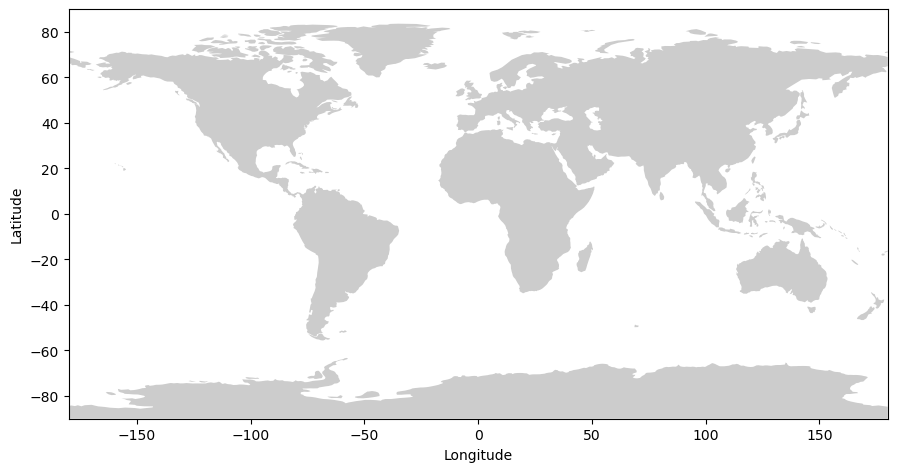

In [3]:
fig,ax1 = plt.subplots(num=1, figsize=(10,4.55))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
world.plot(ax=ax1, color='0.8', edgecolor='none')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

## Geographic Coordinate Systems

Locations on Earth are usually specified in a geographic coordinate system consisting of
- _Longitude_ specifies the angle east and west from the Prime Meridian (102 meters east of the Royal Observatory at Greenwich)
- _Latitude_ specifies the angle north and south from the Equator

The map above _projects_ geographic data from the Earth's 3-dimensional geometry on to a flat surface.  [The three common types of projections are _cylindric_, _conic_ and _planar_](https://courses.washington.edu/gis250/lessons/projection/).  Each type is a different way of flattening the Earth's geometry into 2-dimensional space.

:::{list-table}
:widths: 30 30 30
:align: "center"
:header-rows: 1

*   - Cylindric
    - Conic
    - Planar
*   - ![cylindric](https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/Miller-Cylindrical-Projection-425x233.png?raw=true)
    - ![conic](https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/North-America-Lambert-Conformal-Conic-Projection-425x233.png?raw=true)
    - ![planar](https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/Stereographic-Projection-425x233.png?raw=true)

:::

The above map is in an _Equirectangular Projection_ (Plate Carrée), where latitude and longitude are equally spaced.  Equirectangular is cylindrical projection, which has benefits as latitudes and longitudes form straight lines.  

```{warning}
While simple conceptually, equirectangular projections distort both _shape_ and _distance_, particularly at higher latitudes! So it is not a great choice for data analysis.
```

To illustrate distortion on this map below 👇, we've colored the normalized grid area at different latitudes below:


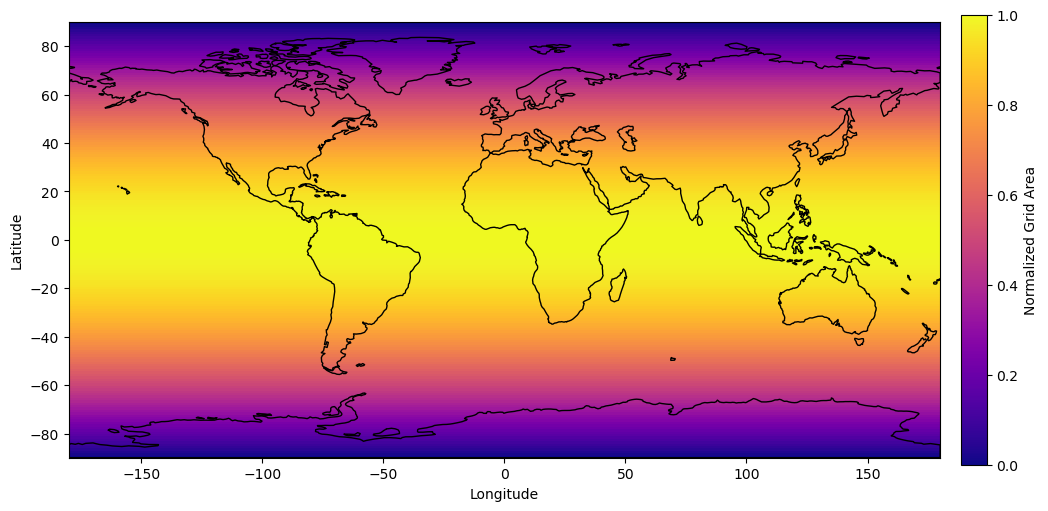

In [4]:
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (1.0,1.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
# calculate and plot grid area
gridlon,gridlat = np.meshgrid(longitude, latitude)
im = ax1.imshow(np.cos(gridlat*np.pi/180.0),
    extent=(minlon,maxlon,minlat,maxlat), 
    interpolation='nearest',
    cmap=plt.get_cmap('plasma'),
    origin='lower')
# add coastlines
world.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Normalized Grid Area')
cbar.solids.set_rasterized(True)
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

### The Components of a Coordinate Reference System (CRS):

* **Projection Information:** the mathematical equation used to flatten objects that are on a round surface (e.g. the earth) so you can view them on a flat surface (e.g. your computer screens or a paper map).
* **Coordinate System:** the X, Y, and Z grid upon which your data is overlaid and how you define where a point is located in space.
* **Horizontal and vertical units:** The units used to define the grid along the x, y (and z) axis.
* **Datum:** A modeled version of the shape of the earth which defines the origin used to place the coordinate system in space. 

👆 Borrowed from [Earth Data Science Coursework](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/spatial-data-vector-shapefiles/intro-to-coordinate-reference-systems-python/)

### Map Projections

* _There is no perfect projection for all purposes_

* Not all maps are good for ocean or land navigation

* Not all projections are good for polar mapping

* Every projection will distort either shape, area, distance or direction:
     * _conformal_ projections minimize distortion in shape
     * _equal-area_ projections minimize distortion in area
     * _equidistant_ projections minimize distortion in distance
     * _true-direction_ projections minimize distortion in direction

While there are [projections that are better suited for specific purposes](https://pubs.usgs.gov/gip/70047422/report.pdf), [choosing a map projection](https://pubs.usgs.gov/pp/1395/report.pdf) is a bit of an art 🦋

```{image} https://imgs.xkcd.com/comics/map_projections.png
:alt: XKCD 977
:width: 35%
:target: https://xkcd.com/977/
:align: center
```
👆 Obligatory [xkcd](https://xkcd.com/977/)

```{admonition}
**Q: What is your favorite projection?** 🌎

**Q: What projections do you use in your research?** 🌏
```

#### Determine your data's CRS

Using [`geopandas`](https://geopandas.org), we can get CRS information about our data:

In [5]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

There are many different ways of [detailing a coordinate reference system (CRS)](https://spatialreference.org/).  Three common CRS formats are:
1. [Well-Known Text (WKT)](https://www.ogc.org/standards/wkt-crs): can describe any coordinate reference system and is the standard for a lot of software

```
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]
```
2. [PROJ string](https://proj.org/): shorter with some less information but can also describe any coordinate reference system

```
+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs 
```
3. [EPSG code](https://epsg.io/): simple and easy to remember

```
EPSG:4326
```

```{admonition} **EPSG:** European Petroleum Survey Group. Back in the day, this group created codes to standardize how different reference systems were referred to, and now EPSG codes are widely used in geospatial work! There are several websites that let you navigate the entire EPSG database: https://epsg.io/4326
```

```{important}
_If CRS metadata on any products isn't included within the data product, make sure it's in the right projection and datum. Often metadata reports or readme files will provide this information._
```

### CRS Transforms of `GeoDataFrames`

The Coordinate Reference System of a [`geopandas` `GeoDataFrame` can be transformed to another](http://geopandas.org/projections.html) using the `to_crs()` function.  The `to_crs()` function can import different forms including WKT strings, PROJ strings, EPSG codes and pyproj CRS objects.

```{warning}
`GeoDataFrames` must have an associated CRS before converting them to a new CRS
```

In [6]:
world_antarctic = world[world.scalerank == 0].to_crs(3031)

##### Did it work?

In [7]:
world_antarctic.crs

<Projected CRS: EPSG:3031>
Name: WGS 84 / Antarctic Polar Stereographic
Axis Info [cartesian]:
- E[north]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Antarctica.
- bounds: (-180.0, -90.0, 180.0, -60.0)
Coordinate Operation:
- name: Antarctic Polar Stereographic
- method: Polar Stereographic (variant B)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

🎉🎉🎉

#### Let's plot our new Antarctic map
🐧🐧🐧

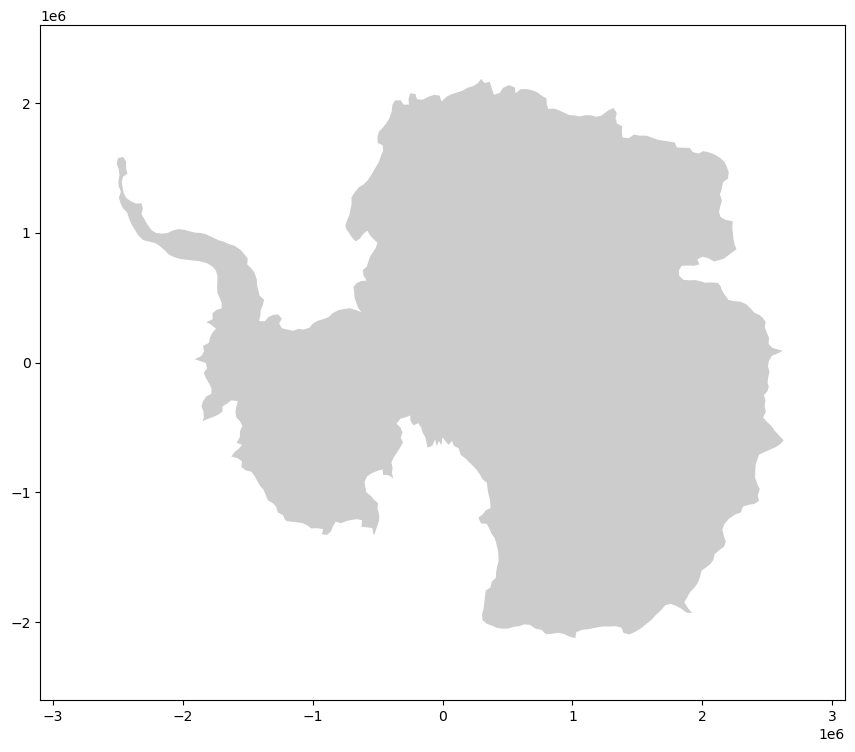

In [8]:
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000)
# add Antarctic coastlines
world_antarctic.plot(ax=ax3, color='0.8', edgecolor='none')
# set x and y limits
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_aspect('equal', adjustable='box')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Stereographic projections are common for mapping in polar regions.  A lot of legacy data products for both Greenland and Antarctica use polar stereographic projections. Some other polar products, such as NSIDC EASE/EASE-2 grids, are in _equal-area_ projections.  

```{warning}
Stereographic projections are _conformal_, preserving angles but not distances or areas.  _Equal-area_ map projection cannot be conformal, nor can a conformal map projection be equal-area.  
```

Here, we'll use the transform to get the latitude and longitude coordinates of points in this projection (an _inverse_ tranformation), and get the polar stereographic coordinates for plotting a circle around the standard parallel (-71°) of this projection (a _forward_ transformation).

The _standard parallel_ of a stereographic projection is the latitude where there is no scale distortion.

In [9]:
def scale_factors(
        lat: np.ndarray,
        flat: float = 1.0/298.257223563,
        reference_latitude: float = 70.0,
        metric: str = 'area'
    ):
    """
    Calculates scaling factors to account for polar stereographic
    distortion including special case of at the exact pole

    Parameters
    ----------
    lat: np.ndarray
        latitude (degrees north)
    flat: float, default 1.0/298.257223563
        ellipsoidal flattening
    reference_latitude: float, default 70.0
        reference latitude (true scale latitude)
    metric: str, default 'area'
        metric to calculate scaling factors

            - ``'distance'``: scale factors for distance
            - ``'area'``: scale factors for area

    Returns
    -------
    scale: np.ndarray
        scaling factors at input latitudes
    """
    assert metric.lower() in ['distance', 'area'], 'Unknown metric'
    # convert latitude from degrees to positive radians
    theta = np.abs(lat)*np.pi/180.0
    # convert reference latitude from degrees to positive radians
    theta_ref = np.abs(reference_latitude)*np.pi/180.0
    # square of the eccentricity of the ellipsoid
    # ecc2 = (1-b**2/a**2) = 2.0*flat - flat^2
    ecc2 = 2.0*flat - flat**2
    # eccentricity of the ellipsoid
    ecc = np.sqrt(ecc2)
    # calculate ratio at input latitudes
    m = np.cos(theta)/np.sqrt(1.0 - ecc2*np.sin(theta)**2)
    t = np.tan(np.pi/4.0 - theta/2.0)/((1.0 - ecc*np.sin(theta)) / \
        (1.0 + ecc*np.sin(theta)))**(ecc/2.0)
    # calculate ratio at reference latitude
    mref = np.cos(theta_ref)/np.sqrt(1.0 - ecc2*np.sin(theta_ref)**2)
    tref = np.tan(np.pi/4.0 - theta_ref/2.0)/((1.0 - ecc*np.sin(theta_ref)) / \
        (1.0 + ecc*np.sin(theta_ref)))**(ecc/2.0)
    # distance scaling
    k = (mref/m)*(t/tref)
    kp = 0.5*mref*np.sqrt(((1.0+ecc)**(1.0+ecc))*((1.0-ecc)**(1.0-ecc)))/tref
    if (metric.lower() == 'distance'):
        # distance scaling
        scale = np.where(np.isclose(theta, np.pi/2.0), 1.0/kp, 1.0/k)
    elif (metric.lower() == 'area'):
        # area scaling
        scale = np.where(np.isclose(theta, np.pi/2.0), 1.0/(kp**2), 1.0/(k**2))
    return scale

In [10]:
crs4326 = pyproj.CRS.from_epsg(4326)    # WGS84
crs3031 = pyproj.CRS.from_epsg(3031)    # Antarctic Polar Stereographic
transformer = pyproj.Transformer.from_crs(crs4326, crs3031, always_xy=True)

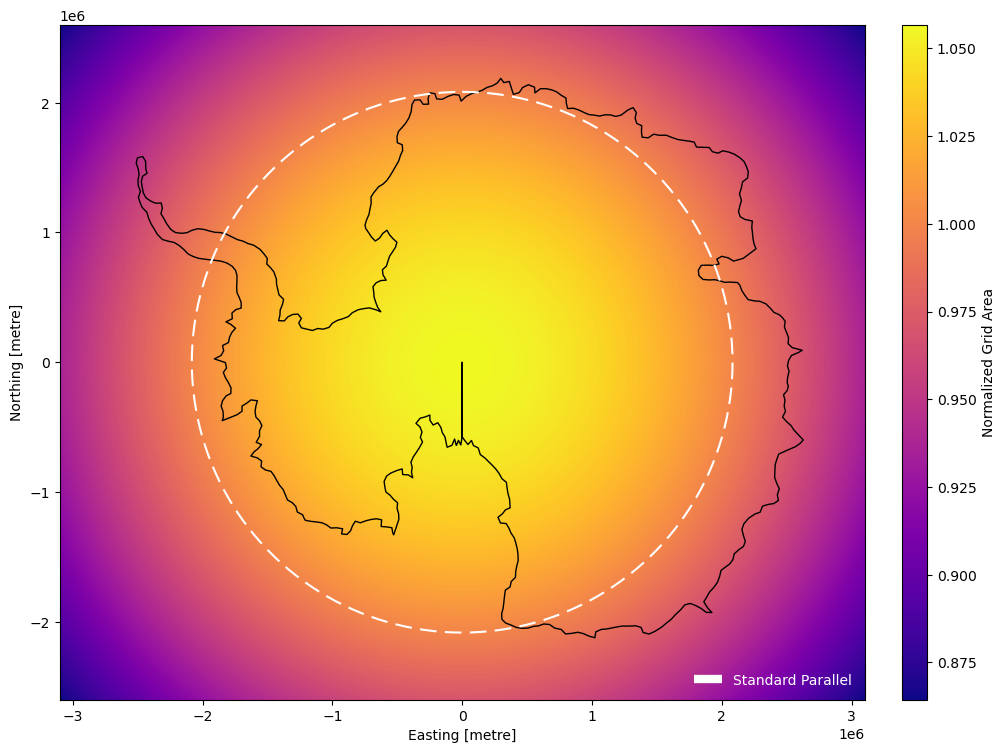

In [11]:
fig,ax3 = plt.subplots(num=3, figsize=(10,7.5))
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000)
dx,dy = (10000,10000)
# create a grid of polar stereographic points
X = np.arange(xmin,xmax+dx,dx)
Y = np.arange(ymin,ymax+dy,dy)
gridx,gridy = np.meshgrid(X, Y)
# convert polar stereographic points to latitude/longitude (WGS84)
gridlon,gridlat = transformer.transform(gridx, gridy,
    direction=pyproj.enums.TransformDirection.INVERSE)
# calculate and plot grid area
cf = crs3031.to_cf()
flat = 1.0/cf['inverse_flattening']
sp = cf['standard_parallel']
gridarea = scale_factors(gridlat, flat=flat, reference_latitude=sp)
im = ax3.imshow(gridarea,
    extent=(xmin,xmax,ymin,ymax), 
    interpolation='nearest',
    cmap=plt.get_cmap('plasma'),
    origin='lower')
# add circle around standard parallel
ref_lon = np.arange(360)
ref_lat = np.ones((360))*sp
# convert latitude/longitude (WGS84) points to polar stereographic
ref_x,ref_y = transformer.transform(ref_lon, ref_lat,
    direction=pyproj.enums.TransformDirection.FORWARD)
l, = ax3.plot(ref_x, ref_y, '--', color='w', dashes=(8,4), label='Standard Parallel')
# add coastlines
world_antarctic.plot(ax=ax3, color='none', edgecolor='black')
# set x and y limits
ax3.set_xlim(xmin,xmax)
ax3.set_ylim(ymin,ymax)
ax3.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3031.axis_info
ax3.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax3.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# add colorbar
cbar = plt.colorbar(im, cax=fig.add_axes([0.92, 0.08, 0.025, 0.90]))
cbar.ax.set_ylabel('Normalized Grid Area')
cbar.solids.set_rasterized(True)
# add legend
lgd = ax3.legend(loc=4,frameon=False)
lgd.get_frame().set_alpha(1.0)
for line in lgd.get_lines():
    line.set_linewidth(6)
for i,text in enumerate(lgd.get_texts()):
    text.set_color(l.get_color())
fig.subplots_adjust(left=0.06,right=0.9,bottom=0.08,top=0.98)

Why is there a black line to the pole?  Because this coastline was reprojected from a Equirectangular projection.  That's the bottom of the Equirectangular map.

### Reproject other data

Often you have other data or contextual information that you need to get into your data's CRS to visualize.

For example, McMurdo Research Station is at (-77.846° S, 166.676° E). How to we plot this without using `geopandas`? 

**`pyproj` transform** objects can be used to change the Coordinate Reference System of arrays

```{important}
Note that most Python libraries do NOT check to make sure your data shares the same CRS. Plotting libraries are not "CRS aware" and will happily plot things in incorrect positions. It is up to you to make sure your positions are accurate.
```

This will transform our latitude and longitude coordinates into coordinates in _meters_ from the map origin

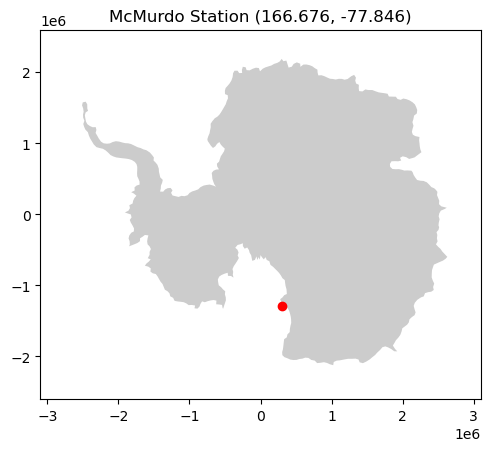

In [12]:
# convert location of McMurdo station to polar stereographic
McMurdo = (166.676, -77.846)
McMurdo_3031 = transformer.transform(*McMurdo)

fig, ax = plt.subplots()
world_antarctic.plot(ax=ax, color='0.8', edgecolor='none')
ax.plot(McMurdo_3031[0], McMurdo_3031[1], 'ro')
# set x and y limits
xmin,xmax,ymin,ymax = (-3100000,3100000,-2600000,2600000)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_aspect('equal', adjustable='box')
ax.set_title(f'McMurdo Station {McMurdo}');

## Reference Systems and Datums

Coordinates are defined to be in _reference_ to the origins of the coordinate system
- Horizontally, coordinates are in reference to the Equator and the Prime Meridian
- Vertically, heights are in reference to a [_datum_](https://vdatum.noaa.gov/docs/datums.html)

Two common vertical datums are the reference _ellipsoid_ and the reference _geoid_.

**What are they and what is the difference?**
- To ﬁrst approximation, the Earth is a sphere (🐄) with a radius of 6371 kilometers.
- To a better approximation, the Earth is a slightly flattened ellipsoid with the polar axis 22 kilometers shorter than the equatorial axis.
- To an even better approximation, the Earth's shape can be described using a reference _geoid_, which undulates 10s of meters above and below the reference ellipsoid. The difference in height between the ellipsoid and the geoid are known as _geoid heights_.

The **geoid** is an _equipotential surface_, perpendicular to the force of gravity at all points and with a constant geopotential. Reference ellipsoids and geoids are both created to largely coincide with mean sea level if the oceans were at rest.

An **ellipsoid** can be considered a _simplification of a geoid_.

```{image} https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/egm2008.png?raw=true
:alt: Derived from the International Centre for Global Earth Models (ICGEM)
:width: 50%
:align: center
```

[`PROJ` hosts grids for shifting both the horizontal and vertical datum](https://cdn.proj.org/), such as gridded [EGM2008 geoid height values](https://cdn.proj.org/us_nga_egm08_25.tif)

```{tip}
If you work with vertical datum offset grids regularly or offline: use the `projsync` command
`projsync --all --quiet`
```

Additional geoid height values can be calculated at the [International Centre for Global Earth Models (ICGEM)](http://icgem.gfz-potsdam.de/home)

![geoid](https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/geoid.gif?raw=true)

Vertically exaggerated, the Earth is sort of like a potato 🥔

Why Does This Matter?
---------------------

ICESat-2 elevations are in reference to a specific version of the WGS84 ellipsoid. There are different "realizations" of the WGS84 ellipsoid. The accuracy of your positioning improves when the specific realization, rather than the ensemble, is used!

```{tip}
Recall above we saw `EPSG:4326` used "Datum: World Geodetic System 1984 ensemble", which is common for older or low-accuracy datasets. [Read more here](https://confluence.qps.nl/qinsy/latest/en/world-geodetic-system-1984-wgs84-182618391.html#id-.WorldGeodeticSystem1984(WGS84)v9.1-WGS84realizations)
```

ICESat-2 data products also include geoid heights from the [EGM2008 geoid](https://www.usna.edu/Users/oceano/pguth/md_help/html/egm96.htm).  Different ground-based, airborne or satellite-derived elevations may use a separate datum entirely.

```{important}
Elevations have to be in the _same reference frame_ when comparing heights.
```

Different datums have different purposes.  Heights above mean sea level are needed for ocean and sea ice heights, and are also commonly used for terrestrial mapping (e.g. as elevations of mountains).  Ellipsoidal heights are commonly used for estimating land ice height change.

```{figure} https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/geodetic-surfaces.png?raw=true
:alt: Geodetic Surfaces
:width: 50%
:align: center

Modified from: Tapley, B. D. & M-C. Kim, Applications to Geodesy, Chapt. 10 in Satellite Altimetry and Earth Sciences, ed. by L-L. Fu & A. Cazenave, Academic Press, pp. 371-406, 2001.
```

```{tip}
Another piece to consider is the _permanent tide system_. ICESat-2 is _tide-free_ but a lot of datasets are _mean tide_. Checkout the [ICESat-2 Data Comparison User's Guide](https://doi.org/10.5281/zenodo.16389970) produced by the ICESat-2 Project Science Office (PSO) for more info.
```

### Terrestrial Reference System

Locations of satellites are determined in an Earth-centered cartesian coordinate system
- **X**, **Y**, and **Z** measurements from the Earth's center of mass

Up to Release-06, ICESat-2 has been set in the [2014 realization of the International Terrestrial Reference Frame (ITRF)](https://itrf.ign.fr/en/solutions/ITRF2014). For Release-07 onward, ICESat-2 will be set in the [2020 realization](https://itrf.ign.fr/en/solutions/ITRF2020). Other satellite and airborne altimetry missions may be in a different ITRF entirely.

As opposed to simple vertical offsets, changing the terrestial reference system can involve both [translation and rotation of the reference system](https://itrf.ign.fr/doc_ITRF/Transfo-ITRF2014_ITRFs.txt).  This involves converting from a geographic coordinate system into a Cartesian coordinate system.

Let's visualize what the Cartesian coordinate system looks like:

In [13]:
def to_cartesian(lon,lat,h=0.0,a_axis=6378137.0,flat=1.0/298.257223563):
    """
    Converts geodetic coordinates to Cartesian coordinates

    Inputs:
        lon: longitude (degrees east)
        lat: latitude (degrees north)

    Options:
        h: height above ellipsoid (or sphere)
        a_axis: semimajor axis of the ellipsoid (default: WGS84)
            * for spherical coordinates set to radius of the Earth
        flat: ellipsoidal flattening (default: WGS84)
            * for spherical coordinates set to 0
    """
    # verify axes
    lon = np.atleast_1d(lon)
    lat = np.atleast_1d(lat)
    # fix coordinates to be 0:360
    lon[lon < 0] += 360.0
    # Linear eccentricity and first numerical eccentricity
    lin_ecc = np.sqrt((2.0*flat - flat**2)*a_axis**2)
    ecc1 = lin_ecc/a_axis
    # convert from geodetic latitude to geocentric latitude
    dtr = np.pi/180.0
    # geodetic latitude in radians
    latitude_geodetic_rad = lat*dtr
    # prime vertical radius of curvature
    N = a_axis/np.sqrt(1.0 - ecc1**2.0*np.sin(latitude_geodetic_rad)**2.0)
    # calculate X, Y and Z from geodetic latitude and longitude
    X = (N + h) * np.cos(latitude_geodetic_rad) * np.cos(lon*dtr)
    Y = (N + h) * np.cos(latitude_geodetic_rad) * np.sin(lon*dtr)
    Z = (N * (1.0 - ecc1**2.0) + h) * np.sin(latitude_geodetic_rad)
    # return the cartesian coordinates
    return (X,Y,Z)

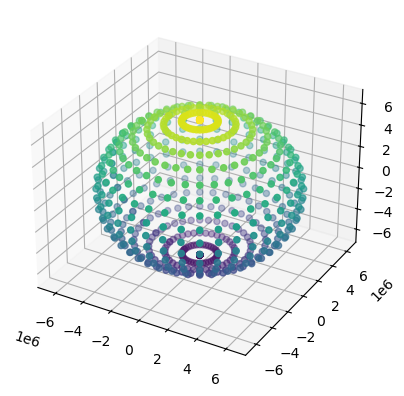

In [14]:
fig,ax2 = plt.subplots(num=2, subplot_kw=dict(projection='3d'))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (10.0,10.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
gridlon,gridlat = np.meshgrid(longitude, latitude)
height = np.zeros_like(gridlon)
X,Y,Z = to_cartesian(gridlon, gridlat, h=height)
ax2.scatter3D(X, Y, Z, c=gridlat)
plt.show()

Yep, that looks like an ellipsoid

## `pyproj` CRS Tricks

`pyproj` CRS objects can:

- Be converted to different methods of describing the CRS, such a to a `PROJ` string or WKT

In [15]:
proj3031 = crs3031.to_proj4()
wkt3031 = crs3031.to_wkt()
assert(crs3031.is_exact_same(pyproj.CRS.from_wkt(wkt3031)))
print(proj3031)

+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs


- Provide information about each coordinate reference system, such as the name, area of use and axes units.

In [16]:
for EPSG in (3031,3413,5936,6931,6932):
  crs = pyproj.CRS.from_epsg(EPSG)
  x_info,y_info = crs.axis_info
  print(f'{crs.name} ({EPSG})')
  print(f'\tRegion: {crs.area_of_use.name}')
  print(f'\tScope: {crs.scope}')
  print(f'\tAxes: {x_info.name} ({x_info.unit_name}), {y_info.name} ({y_info.unit_name})')

WGS 84 / Antarctic Polar Stereographic (3031)
	Region: Antarctica.
	Scope: Antarctic Digital Database and small scale topographic mapping.
	Axes: Easting (metre), Northing (metre)
WGS 84 / NSIDC Sea Ice Polar Stereographic North (3413)
	Region: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
	Scope: Polar research.
	Axes: Easting (metre), Northing (metre)
WGS 84 / EPSG Alaska Polar Stereographic (5936)
	Region: Northern hemisphere - north of 60°N onshore and offshore, including Arctic.
	Scope: Arctic small scale mapping - Alaska-centred.
	Axes: Easting (metre), Northing (metre)
WGS 84 / NSIDC EASE-Grid 2.0 North (6931)
	Region: Northern hemisphere.
	Scope: Environmental science - used as basis for EASE grid.
	Axes: Easting (metre), Northing (metre)
WGS 84 / NSIDC EASE-Grid 2.0 South (6932)
	Region: Southern hemisphere.
	Scope: Environmental science - used as basis for EASE grid.
	Axes: Easting (metre), Northing (metre)


- Get coordinate reference system metadata for including in files

In [17]:
print('Climate and Forecast (CF) conventions')
cf = pyproj.CRS.from_epsg(5936).to_cf()
for key,val in cf.items():
    print(f'\t{key}: {val}')

Climate and Forecast (CF) conventions
	crs_wkt: PROJCRS["WGS 84 / EPSG Alaska Polar Stereographic",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326]],CONVERSION["EPSG Alaska Polar Stereographic",METHOD["Polar Stereographic (variant A)",ID["EPSG",9810]],PARAMETER["Latitude of natural origin",90,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-150,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAME

You can also manually create a _pipeline_ to do coordinate reference systems conversions. These are like recipes for converting coordinate reference systems.

Remember converting latitude and longitude into cartesian coordinates? We can do that with a pipeline!

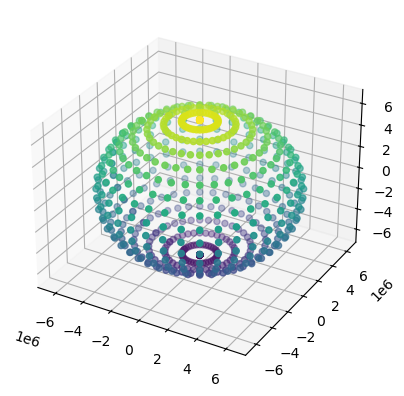

In [18]:
fig,ax2 = plt.subplots(num=2, subplot_kw=dict(projection='3d'))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
dlon,dlat = (10.0,10.0)
longitude = np.arange(minlon,maxlon+dlon,dlon)
latitude = np.arange(minlat,maxlat+dlat,dlat)
gridlon,gridlat = np.meshgrid(longitude, latitude)
height = np.zeros_like(gridlon)
pipeline = """+proj=pipeline
    +step +proj=unitconvert +xy_in=deg +z_in=m +xy_out=rad +z_out=m
    +step +proj=cart +ellps=WGS84"""
transform = pyproj.Transformer.from_pipeline(pipeline)
X,Y,Z = transform.transform(gridlon,gridlat,height)
ax2.scatter3D(X,Y,Z, c=gridlat)
plt.show()

`projinfo` can list possible pipelines for converting between coordinate reference systems

Here is the pipeline `PROJ` chose to convert from latitude and longitude into polar stereographic

In [19]:
!projinfo -s EPSG:4326 -t EPSG:3031 -o PROJ --hide-ballpark --spatial-test intersects

Candidate operations found: 1
-------------------------------------
Operation No. 1:

EPSG:19992, Antarctic Polar Stereographic, 0 m, Antarctica.

PROJ string:
+proj=pipeline
  +step +proj=axisswap +order=2,1
  +step +proj=unitconvert +xy_in=deg +xy_out=rad
  +step +proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84


## Geospatial Data

What is Geospatial Data?  Data that has location information associated with it.

Geospatial data comes in two flavors: _vector_ and _raster_
- Vector data is composed of points, lines, and polygons
- Raster data is composed of individual grid cells

```{figure} https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/vectorraster.png?raw=true
:alt: Vector vs. Raster
:target: https://docs.planet.com/
_Vector vs. Raster from [Planet](https://docs.planet.com/)_
```

```{admonition}
**Q: When would we use vector over raster?**

**Q: When would we use raster over vector?**
```

Vector data will provide geometric information for every point or vertex in the geometry.

Raster data will provide geometric information for a particular corner, which can be combined with the grid cell sizes and grid dimensions to get the grid cell coordinates.

Common vector file formats:
- `GeoJSON`
- `shapefile`
- `GeoPackage`
- ESRI `geodatabase`
- `kml`/`kmz`
- `geoparquet`

Common raster file formats:
- `GeoTIFF`/`cog`
- `jpeg`
- `png`

File formats used for both:
- `netCDF4`
- `HDF5`
- `zarr`

All geospatial data (raster and vector) should have metadata for extracting the coordinate reference system of the data.  Some of this metadata is not included with the files but can be found in the documentation.

```{admonition}
**Q: Are you more familiar with using vector or raster data?**

**Q: Do you more often use GIS software or command-line tools?**
```

There are different tools for working with raster and vector data.  Some are more advantageous for one data type over the other.

Let's find the coordinate reference system of some data products using some common geospatial tools.

### Geospatial Data Abstraction Library

The [Geospatial Data Abstraction Library (GDAL/OGR)](https://gdal.org/) is a powerful piece of software. 

It can read, write and query a wide variety of raster and vector geospatial data formats, transform the coordinate system of images, and manipulate other forms of geospatial data.

It is the backbone of a _large_ suite of geospatial libraries and programs.

There are a number of wrapper libraries (e.g. [`rasterio`](https://rasterio.readthedocs.io/), [`rioxarray`](https://corteva.github.io/rioxarray), [`shapely`](https://shapely.readthedocs.io/), [`fiona`](https://fiona.readthedocs.io/)) that provide more user-friendly interfaces with `GDAL` functionality.

Similar to `pyproj` CRS objects, `GDAL` `SpatialReference` functions can provide a lot of information about a particular Coordinate Reference System

With `GDAL`, we can access _raster_ and _vector_ data that are available over network-based file systems and virtual file systems

- `/vsicurl/`: http/https/ftp files
- `/vsis3/`: AWS S3 files
- `/vsigs/`: Google Cloud Storage files
- `/vsizip/`: zip archives
- `/vsitar/`: tar/tgz archives
- `/vsigzip/`: gzipped files

These can be chained together to access compressed files over networks

### Vector Data

We can use `GDAL` virtual file systems to access the intermediate resolution shapefile of the [Global Self-consistent, Hierarchical, High-resolution Geography Database](https://www.soest.hawaii.edu/pwessel/gshhg/) from its https server.

`ogrinfo` is a GDAL/OGR tool for inspecting vector data.  We'll get a summary (`-so`) of all data (`-al`) in read-only mode (`-ro`).

In [20]:
!ogrinfo -so -al -ro /vsizip//vsicurl/http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip/GSHHS_shp/i/GSHHS_i_L1.shp

INFO: Open of `/vsizip//vsicurl/http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip/GSHHS_shp/i/GSHHS_i_L1.shp'
      using driver `ESRI Shapefile' successful.

Layer name: GSHHS_i_L1
Metadata:
  DBF_DATE_LAST_UPDATE=2017-06-15
Geometry: Polygon
Feature Count: 32830
Extent: (-180.000000, -68.919814) - (180.000000, 83.633389)
Layer SRS WKT:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
id: String (80.0)
level: Integer (9.0)
source: String (80.0)
parent_id: Integer (9.0)
sibling_id: Integer (9.0)
area: Real (24.15)


### Reading Vector Data

In [21]:
gshhg_i = gpd.read_file('/vsizip//vsicurl/http://www.soest.hawaii.edu/pwessel/gshhg/gshhg-shp-2.3.7.zip/GSHHS_shp/i/GSHHS_i_L1.shp')
print(gshhg_i.crs)

EPSG:4326


Let's use these coastlines to make a plot of Greenland in a [Polar Stereographic projection (`EPSG:3413`)](https://epsg.io/3413)

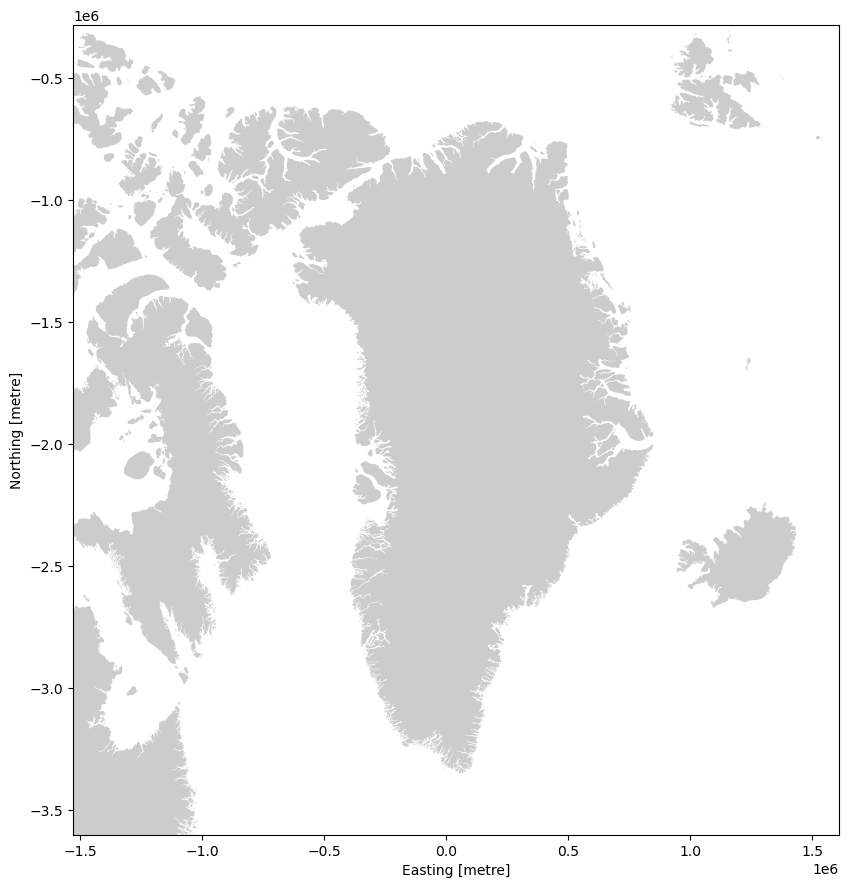

In [22]:
fig,ax4 = plt.subplots(num=4, figsize=(9,9))
crs3413 = pyproj.CRS.from_epsg(3413)
xmin,xmax,ymin,ymax = (-1530000, 1610000,-3600000, -280000)
# add coastlines
gshhg_i.to_crs(crs3413).plot(ax=ax4, color='0.8', edgecolor='none')
# set x and y limits
ax4.set_xlim(xmin,xmax)
ax4.set_ylim(ymin,ymax)
ax4.set_aspect('equal', adjustable='box')
# add x and y labels
x_info,y_info = crs3413.axis_info
ax4.set_xlabel('{0} [{1}]'.format(x_info.name,x_info.unit_name))
ax4.set_ylabel('{0} [{1}]'.format(y_info.name,y_info.unit_name))
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Even with intermediate resolution, we can add much better coastlines than the ones that ship with `geodatasets`!

All coastline resolutions available:
- `c`: coarse
- `l`: low
- `i`: intermediate
- `h`: high
- `f`: full

### Raster Data

The same virtual file system commands can be used with raster images.

Let's inspect some elevation data from the COP3 DEM.

`gdalinfo` allows us to inspect the format, size, geolocation and Coordinate Reference System of raster imagery.  Appending the `-proj4` option will additionally output the PROJ string associated with this geotiff image.

In [23]:
! gdalinfo -proj4 "https://opentopography.s3.sdsc.edu/raster/COP30/COP30_hh/Copernicus_DSM_10_N47_00_W123_00_DEM.tif"

Driver: GTiff/GeoTIFF
Files: none associated
Size is 3601, 3601
Coordinate System is:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        MEMBER["World Geodetic System 1984 (G2139)"],
        MEMBER["World Geodetic System 1984 (G2296)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
       

### Reading Raster Data

We can read geotiff files using `rasterio`, which is a wrapper of `GDAL` for reading raster data

In [24]:
url = "https://opentopography.s3.sdsc.edu/raster/COP30/COP30_hh/Copernicus_DSM_10_N47_00_W123_00_DEM.tif"
ds = rioxarray.open_rasterio(url, masked=True).isel(band=0)
ds

<xarray.DataArray (y: 3601, x: 3601)> Size: 52MB
[12967201 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -123.0 -123.0 -123.0 ... -122.0 -122.0 -122.0
  * y            (y) float64 29kB 48.0 48.0 48.0 48.0 ... 47.0 47.0 47.0 47.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0
    units:          metre

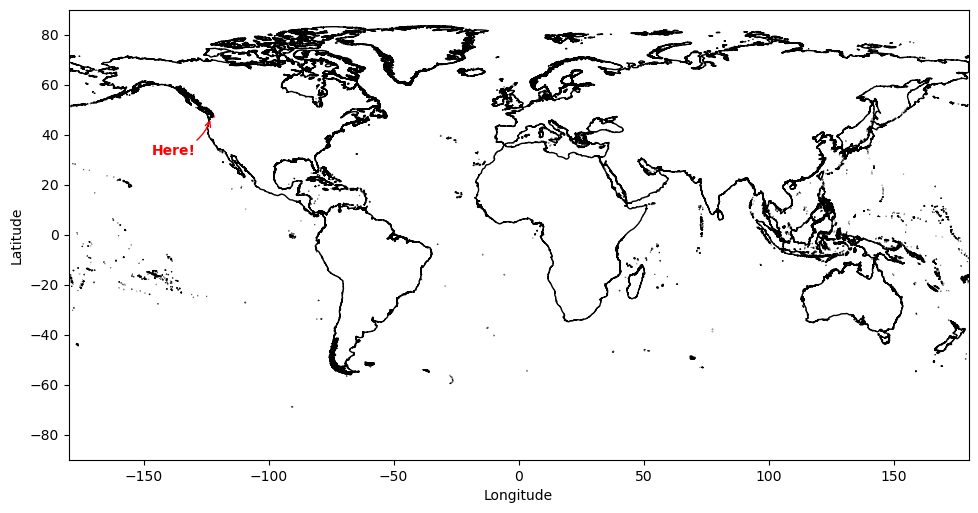

In [25]:
# plot location of DEM
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
minlon,maxlon,minlat,maxlat = (-180,180,-90,90)
# add geometry of image
xmin, ymin, xmax, ymax = ds.rio.transform_bounds('EPSG:4326')
box = gpd.GeoSeries(shapely.geometry.box(xmin, ymin, xmax, ymax))
box.plot(ax=ax1,facecolor='red',edgecolor='red',alpha=0.5)
# add annotation
ax1.annotate("Here!", xy=(xmin,ymin), xytext=(xmin-15.0, ymin-15.0),
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.3",color='red'),
    bbox=dict(boxstyle="square", fc="w", ec="w", pad=0.1),
    color='red', weight='bold', xycoords='data', ha='center')
# add GSHHG coastlines
gshhg_i.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(minlon,maxlon)
ax1.set_ylim(minlat,maxlat)
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

Okay! It covers Seattle and the University of Washington.

Let's see what the DEM looks like for this granule

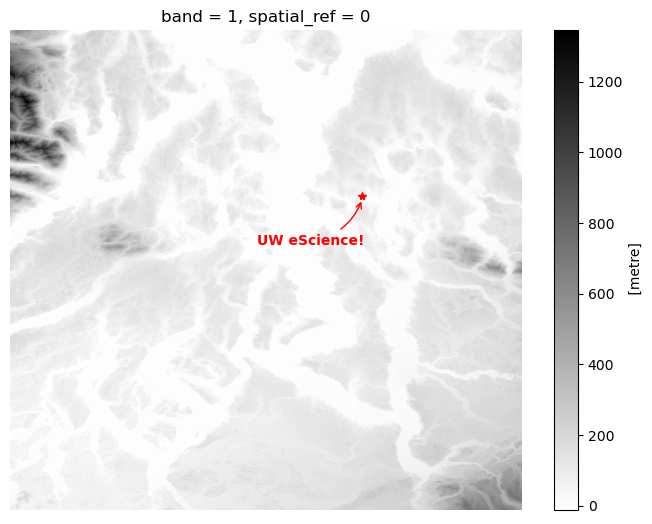

In [26]:
# create figure axis
fig, ax = plt.subplots(num=5)
im = ds.plot.imshow(ax=ax, interpolation='nearest',
    vmin=ds.values.min(), vmax=ds.values.max(),
    cmap=plt.cm.gray_r)
x,y = (-122.3117, 47.6533)
ax.plot(x, y, 'r*')
# add annotation
ax.annotate("UW eScience!", xy=(x,y-0.005), xytext=(x-0.1, y-0.1),
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.3",color='red'),
    color='red', weight='bold', xycoords='data', ha='center')
# turn of frame and ticks
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')
# adjust subplot within figure
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

### Warping Raster Imagery

_Warping_ transfers a raster image from one Coordinate Reference System (CRS) into another.

We can use [`GDAL` to reproject the imagery data](https://gdal.org/programs/gdalwarp.html) into another CRS or change the pixel resolution of the raster image.

Ground control points (GCPs) can also be applied to georeference raw maps or imagery.

```{figure} https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/auspr18_Georefer_2.gif?raw=true
:alt: ESRI warp
:target: https://www.esri.com/about/newsroom/wp-content/uploads/2018/07/auspr18_Georefer_2.gif

_Raster Georeferencing from [ESRI](https://www.esri.com/about/newsroom/arcuser/understanding-raster-georeferencing/)_
```

#### Rasterio Transforms

For every `rasterio` object, there is an associated _affine transform_ (`ds.transform`), which allows you to [transfer from image coordinates to geospatial coordinates](https://rasterio.readthedocs.io/en/latest/quickstart.html#dataset-georeferencing).

$
x = A*row + B*col + C\\
y = D*row + E*col + F
$

_Affine Transformation_: maps between pixel locations in `(row, col)` coordinates to `(x, y)` spatial positions:

`x,y = ds.transform*(row,col)`

Upper left coordinate:
- `row = 0`
- `col = 0`

Lower right coordinate:
- `row = ds.width`
- `col = ds.height`

```{figure} https://github.com/tsutterley/icesat-2-geophysical-transforms/blob/main/aufall18_Georefer_1.gif?raw=true
:alt: ESRI affine
:target: https://www.esri.com/about/newsroom/wp-content/uploads/2018/07/aufall18_Georefer_1.gif

_Raster Georeferencing from [ESRI](https://www.esri.com/about/newsroom/arcuser/understanding-raster-georeferencing/)_
```

`rioxarray` does these affine transformations under the hood when reprojecting images. We can use these tools to warp our raster image into a lower resolution.

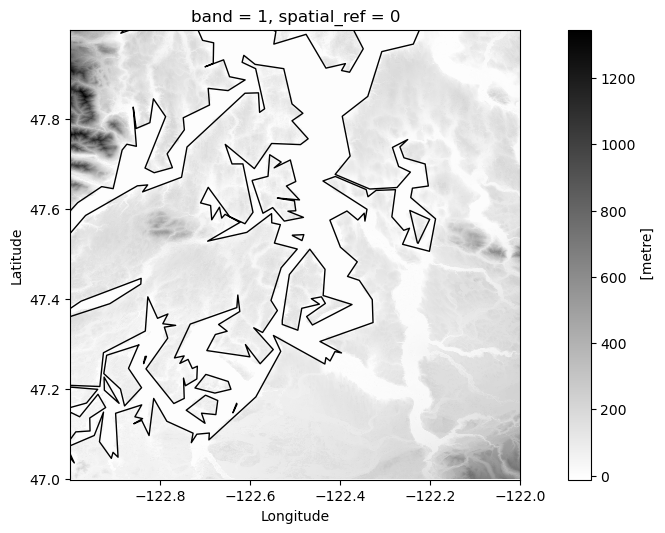

In [27]:
# degrade resolution from 1 arcsecond to 8 arcseconds
dst_res = 8.0/3600.0
warped = ds.rio.reproject(crs4326, resolution=(dst_res,dst_res))

# plot warped DEM
fig,ax1 = plt.subplots(num=1, figsize=(10.375,5.0))
# add geometry of image
im = warped.plot.imshow(ax=ax1, interpolation='nearest',
    vmin=ds.values.min(), vmax=ds.values.max(),
    cmap=plt.cm.gray_r)
# add coastlines
gshhg_i.plot(ax=ax1, color='none', edgecolor='black')
# set x and y limits
ax1.set_xlim(warped.x.min(), warped.x.max())
ax1.set_ylim(warped.y.min(), warped.y.max())
ax1.set_aspect('equal', adjustable='box')
# add x and y labels
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
# adjust subplot and show
fig.subplots_adjust(left=0.06,right=0.98,bottom=0.08,top=0.98)

```{tip}
We might have wanted to use the full resolution coastlines!
```

#### Saving Raster Data with `rioxarray`

In [28]:
# write an array as a raster band
# copernicus DEM naming convention for spacing:
# 03: 0.3-arcsecond grid, 04: 0.4-arcsecond grid, 10: 1-arcsecond grid, 30: 3-arcsecond grid
warped.rio.to_raster('Copernicus_DSM_80_N47_00_W123_00_DEM.tif', driver='cog')

## Applying Concepts: ICESat-2

Let's take what we just learned and apply it to ICESat-2

We'll download a granule of ICESat-2 ATL06 land ice heights from the [National Snow and Ice Data Center (NSIDC)](https://nsidc.org/data/atl06).  ATL06 is _along-track_ data stored in an HDF5 file with geospatial coordinates latitude and longtude (WGS84).  Within an ATL06 file, there are six beam groups (`gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, `gt3r`) that correspond to the orientation of the beams on the ground.

In [29]:
def build_granule_name(short_name, track, cycle, hemisphere=None, granule=None):
    # repeat ground track (RGT)
    tttt = str(track).zfill(4)
    # orbital cycle
    cc = str(cycle).zfill(2)
    # ice hemisphere flag (01=north, 02=south) 
    hh = str(hemisphere).zfill(2) if hemisphere is not None else "??"
    # granule number (ranges from 1-14, always 01 for atmosphere products)
    nn = str(granule).zfill(2) if granule is not None else "??"
    # patterns vary by product
    along_track_products = ("ATL03", "ATL04", "ATL06", "ATL08",
        "ATL09", "ATL10", "ATL12", "ATL13", "ATL16", "ATL17",
        "ATL19", "ATL22", "ATL24")
    sea_ice_products = ("ATL07", "ATL10", "ATL20", "ATL21")
    # use single character wildcards "?" for any unset parameters
    if short_name in sea_ice_products:
        return f"{short_name}-{hh}_{14 * '?'}_{tttt}{cc}??_*"
    elif short_name in along_track_products:
        return f"{short_name}_{14 * '?'}_{tttt}{cc}{nn}_*"

In [ ]:
# build credentials for accessing ICESat-2 data
earthaccess.login(strategy='interactive', persist=True)
auth = earthaccess.login()
# query CMR for ATL06 files
pattern = build_granule_name(short_name="ATL06", track=9, cycle=14, granule=12)
granules = earthaccess.search_data(
    short_name="ATL06",
    granule_name=pattern,
)
granules[0]

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L3A Land Ice Height V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 157.06831, 'Latitude': -68.62658}, {'Longitude': 156.75416, 'Latitude': -68.63942}, {'Longitude': 156.82033, 'Latitude': -68.85662}, {'Longitude': 157.10645, 'Latitude': -69.70312}, {'Longitude': 157.40866, 'Latitude': -70.5414}, {'Longitude': 157.73774, 'Latitude': -71.39247}, {'Longitude': 158.00061, 'Latitude': -72.03037}, {'Longitude': 158.57475, 'Latitude': -73.30533}, {'Longitude': 158.89007, 'Latitude': -73.94222}, {'Longitude': 159.22696, 'Latitude': -74.57739}, {'Longitude': 159.88325, 'Latitude': -75.69844}, {'Longitude': 160.29697, 'Latitude': -76.33347}, {'Longitude': 160.6895, 'Latitude': -76.89064}, {'Longitude': 161.13725, 'Latitude': -77.47765}, {'Longitude': 161.30236, 'Latitude': -77.68223}, {'Longitude': 161.46579, 'Latitude': -77.87882}, {'Longitude': 161.64377, 'Latitude': -78.08655}, {'Longitude': 161.81463, 'Latitude': -78.27999}, {'Longitude': 162.00098, 'Latitude': -78.48437}, {'Longitude': 162.19948, 'Latitude': -78.69495}, {'Longitude': 162.55218, 'Latitude': -79.0505}, {'Longitude': 163.14288, 'Latitude': -79.02811}, {'Longitude': 162.77461, 'Latitude': -78.67317}, {'Longitude': 162.56607, 'Latitude': -78.46293}, {'Longitude': 162.37031, 'Latitude': -78.25886}, {'Longitude': 162.19083, 'Latitude': -78.06572}, {'Longitude': 162.00388, 'Latitude': -77.85827}, {'Longitude': 161.83223, 'Latitude': -77.66194}, {'Longitude': 161.65883, 'Latitude': -77.45763}, {'Longitude': 161.18874, 'Latitude': -76.8714}, {'Longitude': 160.77671, 'Latitude': -76.31486}, {'Longitude': 160.34257, 'Latitude': -75.68051}, {'Longitude': 159.65427, 'Latitude': -74.56052}, {'Longitude': 159.30114, 'Latitude': -73.92577}, {'Longitude': 158.97081, 'Latitude': -73.28934}, {'Longitude': 158.36984, 'Latitude': -72.01527}, {'Longitude': 158.09485, 'Latitude': -71.37762}, {'Longitude': 157.75091, 'Latitude': -70.52699}, {'Longitude': 157.43527, 'Latitude': -69.68909}, {'Longitude': 157.13669, 'Latitude': -68.84292}, {'Longitude': 157.06831, 'Latitude': -68.62658}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2021-12-22T21:45:39.248Z', 'EndingDateTime': '2021-12-22T21:48:24.642Z'}}
Size(MB): 61.175737380981445
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL06/006/2021/12/22/ATL06_20211222214540_00091412_006_01.h5']

In [32]:
# download or stream ATL06 granules
if (AWS_DEFAULT_REGION == 'us-west-2'):
    buffers = earthaccess.open(granules)
else:
    buffers = earthaccess.download(granules, local_path='.')
# read multiple HDF5 groups and merge into a dataset
groups = ['gt1l/land_ice_segments', 'gt1l/land_ice_segments/dem']
ds = xr.merge([xr.open_dataset(buffers[0], group=g) for g in groups])
# inspect ATL06 data for beam group
ds

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 3MB
Dimensions:                (delta_time: 52486)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 420kB 2021-12-22T21:45...
    latitude               (delta_time) float64 420kB ...
    longitude              (delta_time) float64 420kB ...
Data variables:
    atl06_quality_summary  (delta_time) int8 52kB ...
    h_li                   (delta_time) float32 210kB ...
    h_li_sigma             (delta_time) float32 210kB ...
    segment_id             (delta_time) float64 420kB ...
    sigma_geo_h            (delta_time) float32 210kB ...
    dem_flag               (delta_time) int8 52kB ...
    dem_h                  (delta_time) float32 210kB ...
    geoid_free2mean        (delta_time) float32 210kB ...
    geoid_h                (delta_time) float32 210kB ...
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...

`xarray` has a handy `to_dataframe` function to convert to `pandas`

In [33]:
# For simplicity take first 500 high-quality points into a Geopandas Geodataframe
df = ds.where(ds.atl06_quality_summary==0).isel(delta_time=slice(0,500)).to_dataframe()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:7661')
gdf.head()

,atl06_quality_summary,h_li,h_li_sigma,segment_id,sigma_geo_h,dem_flag,dem_h,geoid_free2mean,geoid_h,latitude,longitude,geometry
delta_time,,,,,,,,,,,,
2021-12-22 21:45:39.283526032,0.0,2.839937,0.012993,1565342.0,0.135919,4.0,0.821349,-0.242105,-51.517769,-79.005745,162.651384,POINT (162.65138 -79.00575)
2021-12-22 21:45:39.286340896,0.0,2.945749,0.012692,1565343.0,0.130238,4.0,0.821336,-0.242104,-51.517719,-79.005571,162.651199,POINT (162.6512 -79.00557)
2021-12-22 21:45:39.289157344,0.0,2.889958,0.016177,1565344.0,0.131571,4.0,0.858527,-0.242104,-51.517654,-79.005396,162.651015,POINT (162.65102 -79.0054)
2021-12-22 21:45:39.291975808,0.0,2.989029,0.015763,1565345.0,0.152175,4.0,0.920019,-0.242103,-51.517586,-79.005221,162.650832,POINT (162.65083 -79.00522)
2021-12-22 21:45:39.294796336,0.0,3.211246,0.012485,1565346.0,0.135500,4.0,0.998561,-0.242103,-51.517521,-79.005046,162.650651,POINT (162.65065 -79.00505)


use `explore` to create an interactive map of our ICESat-2 points

In [34]:
gdf.explore(column='h_li')

### Copernicus DEM

Let's compare ICESat-2 elevations against a public, gridded global digital elevation model (DEM), the [Copernicus DEM](https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.3). This DEM is with respect to the EGM2008 geoid, and so we'll have to convert our ICESat-2 points to be comparable.

Just as Geopandas adds CRS-aware capabilities to Dataframes, RioXarray adds CRS-aware functions to XArray multidimensional arrays (e.g. sets of images).

In [35]:
COP30 = rioxarray.open_rasterio('https://opentopography.s3.sdsc.edu/raster/COP30/COP30_hh.vrt', chunks=True)
# Crop by Bounding box of all the ATL06 points
minx, miny, maxx, maxy = gdf.total_bounds
COP30 = COP30.rio.clip_box(minx, miny, maxx, maxy).sel(band=1)
COP30

<xarray.DataArray (y: 316, x: 320)> Size: 404kB
dask.array<getitem, shape=(316, 320), dtype=float32, chunksize=(316, 320), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 3kB 162.6 162.6 162.6 162.6 ... 162.7 162.7 162.7
  * y            (y) float64 3kB -78.92 -78.92 -78.92 ... -79.01 -79.01 -79.01
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    scale_factor:   1.0
    add_offset:     0.0

### Convert ATL06 Ellipsoidal Heights to Orthometric
Check out the [ICESat-2 User Comparison Guide](https://doi.org/10.5281/zenodo.16389970) for more info

In [36]:
gdf['h_ortho'] = gdf.h_li - (gdf.geoid_h + gdf.geoid_free2mean)
# calculate elevation difference between ATL06 and COP30
x = xr.DataArray(gdf.geometry.x.values, dims='z')
y = xr.DataArray(gdf.geometry.y.values, dims='z')
gdf['dh'] = gdf.h_ortho - COP30.sel(x=x, y=y, method='nearest')

### Compare COP30 DEM with ATL06

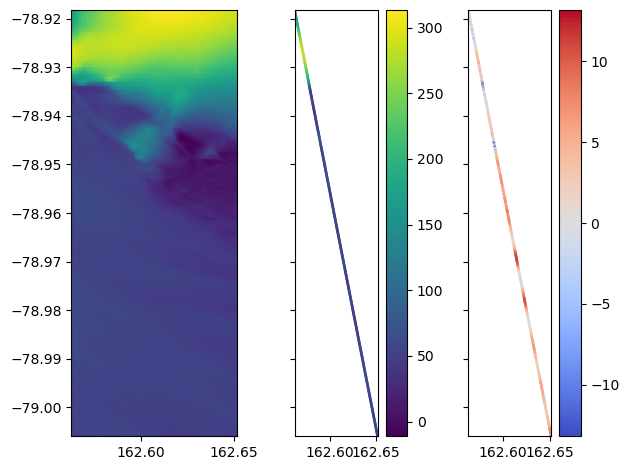

In [37]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)
cmap1 = plt.get_cmap('viridis')
cmap2 = plt.get_cmap('coolwarm')
vmin = np.minimum(COP30.min().values, gdf.h_ortho.min())
vmax = np.maximum(COP30.max().values, gdf.h_ortho.max())
COP30.plot.imshow(ax=ax[0], cmap=cmap1, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)
gdf.plot(column="h_ortho", ax=ax[1], cmap=cmap1, vmin=vmin, vmax=vmax, markersize=1, legend=True)
gdf.plot(column="dh", ax=ax[2], cmap=cmap2, norm=mcolors.CenteredNorm(), markersize=1, legend=True)
fig.tight_layout()
plt.show()

## Resources

There is a _lot_ of great educational material to learn more about these topics. We recommend checking out:

* [UW Cryo 3D CRS Guide](https://uw-cryo.github.io/3D_CRS_Transformation_Resources/)
* [UW Geospatial Data Analaysis with Python](https://uwgda-jupyterbook.readthedocs.io/en/latest/intro.html)
* [PennState GPS & GNSS for Geospatial Professionals](https://www.e-education.psu.edu/geog862/node/1794)
* [Qinsy Geodetic Documentation](https://confluence.qps.nl/qinsy/latest/en/how-to-geodetic-items-235803916.html)
* [GISGeography](https://gisgeography.com/)